<a href="https://colab.research.google.com/github/alexisporcel/ReteX/blob/main/Dorade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# load the data
data = pd.read_table("4_1_23_v1.csv", delimiter=",", index_col=False, low_memory=False)
print(data.columns)
del data['Epoch']

# frequency of acquisition
frequency = int(data.columns[0][5:8])
duration = int(0.5*frequency)
print('frequency =', frequency, 'and duration =', duration)

dataWithMarker = data[~data['Event Id'].isnull()]

print(len(dataWithMarker['Event Id']))

errorIndex = dataWithMarker.loc[dataWithMarker['Event Id'].str.contains('1')].index.tolist()
nonErrorIndex = dataWithMarker.loc[dataWithMarker['Event Id'].str.contains('0')].index.tolist()

# ErrorAcquisition=[acquisition]
# acquisition = [[time],[channel1],[channel2],...]

ErrorAcquisition = []
for index in errorIndex:
    list = data.iloc[index - duration // 2:index + duration // 2][data.columns[0:33]].values.tolist()
    ErrorAcquisition.append(np.array(list).T.tolist())

nonErrorAcquisition = []
for index in nonErrorIndex:
    list = data.iloc[index - duration // 2:index + duration // 2][data.columns[0:33]].values.tolist()
    nonErrorAcquisition.append(np.array(list).T.tolist())

reference = [ErrorAcquisition[0][0]]

for j in range(1, len(ErrorAcquisition[0])):
    reference.append(
        (np.mean(np.array([ErrorAcquisition[i][j] for i in range(len(ErrorAcquisition))]), axis=0)).tolist())


def Error():
    return ErrorAcquisition


def nonError():
    return nonErrorAcquisition


def reference():
    return reference


Index(['Time:500Hz', 'Epoch', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
       'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5',
       'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1',
       'Oz', 'O2', 'PO10', 'Event Id', 'Event Date', 'Event Duration'],
      dtype='object')
frequency = 500 and duration = 250
37


# Vecteurs

In [ ]:
def acquisition_vector(acqui):
  ##Renvoie la matrice des feature vectors des 32 électrodes pour 1 acquisition
  lg=len(acqui)
  vec=[]
  for i in range (1,lg):
    electrode=acqui[i]
    minimum=min(electrode)
    maximum=max(electrode)
    moy=np.mean(electrode)
    ecartt=np.std(electrode)
    vector_param=[minimum,maximum,moy,ecartt]
    vec.append(vector_param)
  return vec



In [ ]:
def Experiment_vector(experiment) : 
  ##renvoie un tableau des acquisition_vector (cad des matrices des feature vectors des 32 electrodes)
    exp_vec = []
    for i in range(len(experiment)): 
      exp_vec.append(acquisition_vector(experiment[i]))
    return exp_vec


In [ ]:
Experiment_vector(Error())

In [ ]:
def Error_indexation(experiment_vec) : 
  ##ajoute un string 'Error' à la fin d'un acquisition_vector pour lui donner un label Error 
  for i in range(len(experiment_vec)) : 
    experiment_vec[i].append('Error')
  return experiment_vec

In [ ]:
def Non_Error_indexation(experiment_vec) : 
  ##ajoute un string 'Error' à la fin d'un acquisition_vector pour lui donner un label Success
  for i in range(len(experiment_vec)) : 
    experiment_vec[i].append('Success')
  return experiment_vec

In [ ]:
Error_indexation(Experiment_vector(Error()))

In [ ]:
data = Error_indexation(Experiment_vector(Error())) + Non_Error_indexation(Experiment_vector(nonError()))
#concatenation des données Erreur et Succes
print(data)

In [ ]:
import random

random.shuffle(data)
#Mélanger le set de données Erreur+Succes


In [ ]:
def separation(data):
  #Sépare les acquisition_vector de leur label : renvoie un tableau de deux tableaux
  raw_data = []
  label = []
  for i in range(len(data)) : 
    raw_data.append(data[i][0:-1])
    if data[i][-1]=='Error' : 
      label.append(1)
    else : 
      label.append(0)
  return [raw_data,label]
    


In [ ]:
print(data)

In [ ]:
raw_data, label=separation(data)

In [ ]:
def averaged_vector(raw_data) : 
  ##Fait un vecteur moyen des 32 électrodes de 1 acquisition : renvoie une liste des vecteurs moyens de chaque acquisition
  raw_data_bis=[]
  for acquisition in raw_data : 
    vector_acquisition = []
    for j in range(4) : 
      sum=0
      for i in range(len(acquisition)) : 
        sum+=acquisition[i][j]
      sum = sum/(len(acquisition))
      vector_acquisition.append(sum)
    raw_data_bis.append(vector_acquisition)
  return raw_data_bis


In [ ]:
averaged_raw_data = averaged_vector(raw_data)


  # SVM

In [ ]:
# import required libraries
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# load dataset


# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(averaged_raw_data, label, test_size=0.2, random_state=42)

# create an SVM classifier with linear kernel
clf_linear = svm.SVC(kernel='linear')

# train the classifier on the training set
clf_linear.fit(X_train, y_train)

# predict the labels of the test set
y_pred_linear = clf_linear.predict(X_test)

# calculate the accuracy of the classifier
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print("Accuracy with linear kernel:", accuracy_linear)

# create an SVM classifier with RBF kernel
clf_rbf = svm.SVC(kernel='rbf')

# train the classifier on the training set
clf_rbf.fit(X_train, y_train) 

# predict the labels of the test set
y_pred_rbf = clf_rbf.predict(X_test)

# calculate the accuracy of the classifier
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("Accuracy with RBF kernel:", accuracy_rbf)


Accuracy with linear kernel: 0.8387096774193549
Accuracy with RBF kernel: 0.8387096774193549


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


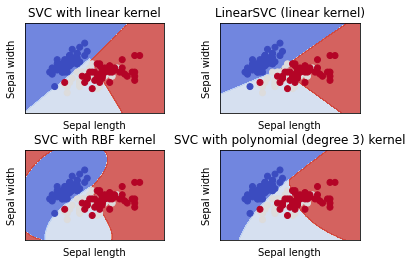

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

# Classification par Offset

In [ ]:
Error_data_feature_vectors = averaged_vector(Experiment_vector(Error()))
Non_Error_data_feature_vectors =  averaged_vector(Experiment_vector(nonError()))


In [ ]:
def AFV(feature_vectors) :
  #renvoie le Averaged Feature Vector : renvoie la moyenne des feature_vector à partir de toutes les acquisitions 
  AFV=[] 
  for i in range(4) :
    sum=0
    for j in range(len(feature_vectors)) : 
      sum+=feature_vectors[j][i]
    AFV.append(sum/len(feature_vectors))
  return AFV
    

In [ ]:
Error_AFVector = AFV(Error_data_feature_vectors)
Non_Error_AFVector = AFV(Non_Error_data_feature_vectors)

In [ ]:
def distance_to_AFV(featured_vector, AFVector):
  a1 = np.array(featured_vector)
  a2 = np.array(AFVector) 
  return np.linalg.norm(a1-a2,2)


In [ ]:
def distance_table(FV_table, AFVector) : 
  distance_table = []
  for i in range(len(FV_table)):
    distance_table.append(distance_to_AFV(FV_table[i],AFVector))
  return distance_table


In [ ]:
Error_distance_table = distance_table(Error_data_feature_vectors,Non_Error_AFVector)
Non_Error_distance_table = distance_table(Non_Error_data_feature_vectors, Non_Error_AFVector)

In [ ]:
print(np.mean(Error_distance_table))

109.88070523305817


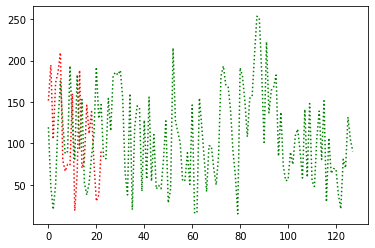

In [ ]:
y1=np.zeros_like(Error_distance_table)
y2=np.zeros_like(Non_Error_distance_table)
plt.plot(Error_distance_table, ls='dotted', c='red')
plt.plot(Non_Error_distance_table,ls='dotted', c='green')
plt.show() 

In [ ]:
print(np.mean(Non_Error_distance_table))

108.02382489112202


Conclusion : Une approche "naïve" en essayant de trouver un écart à l'AFV n'est pas concluant car nous n'arrivons pas à scinder deux groupes distincts de données afin de classifier en Succès ou Erreur. Il faut une méthode dynamique qui s'adapte en fonction des résultats, comme par exemple SVM. 

# Filtrage

In [ ]:
import scipy
import numpy as np
import csv
import sys
import os
from numpy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt




# Convertit le fichier csv en tableau2D python (les 2 premieres lignes)

def convertColumn():
    with open(r"../Data ICM/4_1_23_v3.csv", 'r') as file:
        csvreader = csv.reader(file)
        X = [[] for i in range(37)]
        k = 0
        for row in csvreader:
            if (k>0):
                for i in range(37):
                    if row[i] != '':
                        X[i].append(float(row[i]))
            k=1
        return X

def filterSignal(column, wc, freq_ech): # Retourne le signal filtré par un passe-bas parfait à wcHz. L'indice de colonne est à prendre entre 2 et 33
    Fs = freq_ech                         # sampling rate
    Ts = 1.0/Fs
    t = np.arange(0,180,Ts)
    y = convertColumn()[column][:90000]
    
    #Original signal
    plt.subplot(3,1,1)
    plt.plot(t,y,'k-')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    
    #FFT Transform cutted to 15Hz
    plt.subplot(3,1,2)
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    freq = frq[range(n//2)]  # one side frequency range
    
    #Filtrage des harmonique par un passe-bas parfait à 15Hz.
    cut_nb = int(wc/freq[1]) # Passe-bas parfait
    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    plt.plot(freq[:cut_nb+1], abs(Y)[:cut_nb+1], 'r-')
    plt.xlim(0,15)
    plt.ylim(0,20)
    for i in range(cut_nb+1,len(Y)):
        Y[i] = 0
    plt.xlabel('freq (Hz)')
    plt.ylabel('|Y(freq)|')
    
    #FFT Inverse
    plt.subplot(3,1,3)
    Z = np.fft.ifft(Y)*n
    Z = Z[range(n//2)]
    plt.plot(Z)
    plt.show()
    return Z

filterSignal(33, 15, 500)